In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the preprocessed data
train_df = pd.read_csv('../data/processed/train_x_add_features.csv')
test_df = pd.read_csv('../data/processed/test_x_add_features.csv')

# 分割
X = train_df.drop(columns=['win'], axis=1)
y = train_df['win']
X_test = test_df.drop(columns=['win'], axis=1)

# train/validation split
# stratifyオプション→目的変数の分布を保ったまま分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape


((115200, 42), (28800, 42), (115200,), (28800,), (36000, 44))

In [3]:
# 分布の確認
print("Train win distribution:")
print(y_train.value_counts(normalize=True))
print("\nValidation win distribution:")
print(y_val.value_counts(normalize=True))

Train win distribution:
win
0    0.500286
1    0.499714
Name: proportion, dtype: float64

Validation win distribution:
win
0    0.500278
1    0.499722
Name: proportion, dtype: float64


# 追加した特徴量の確認

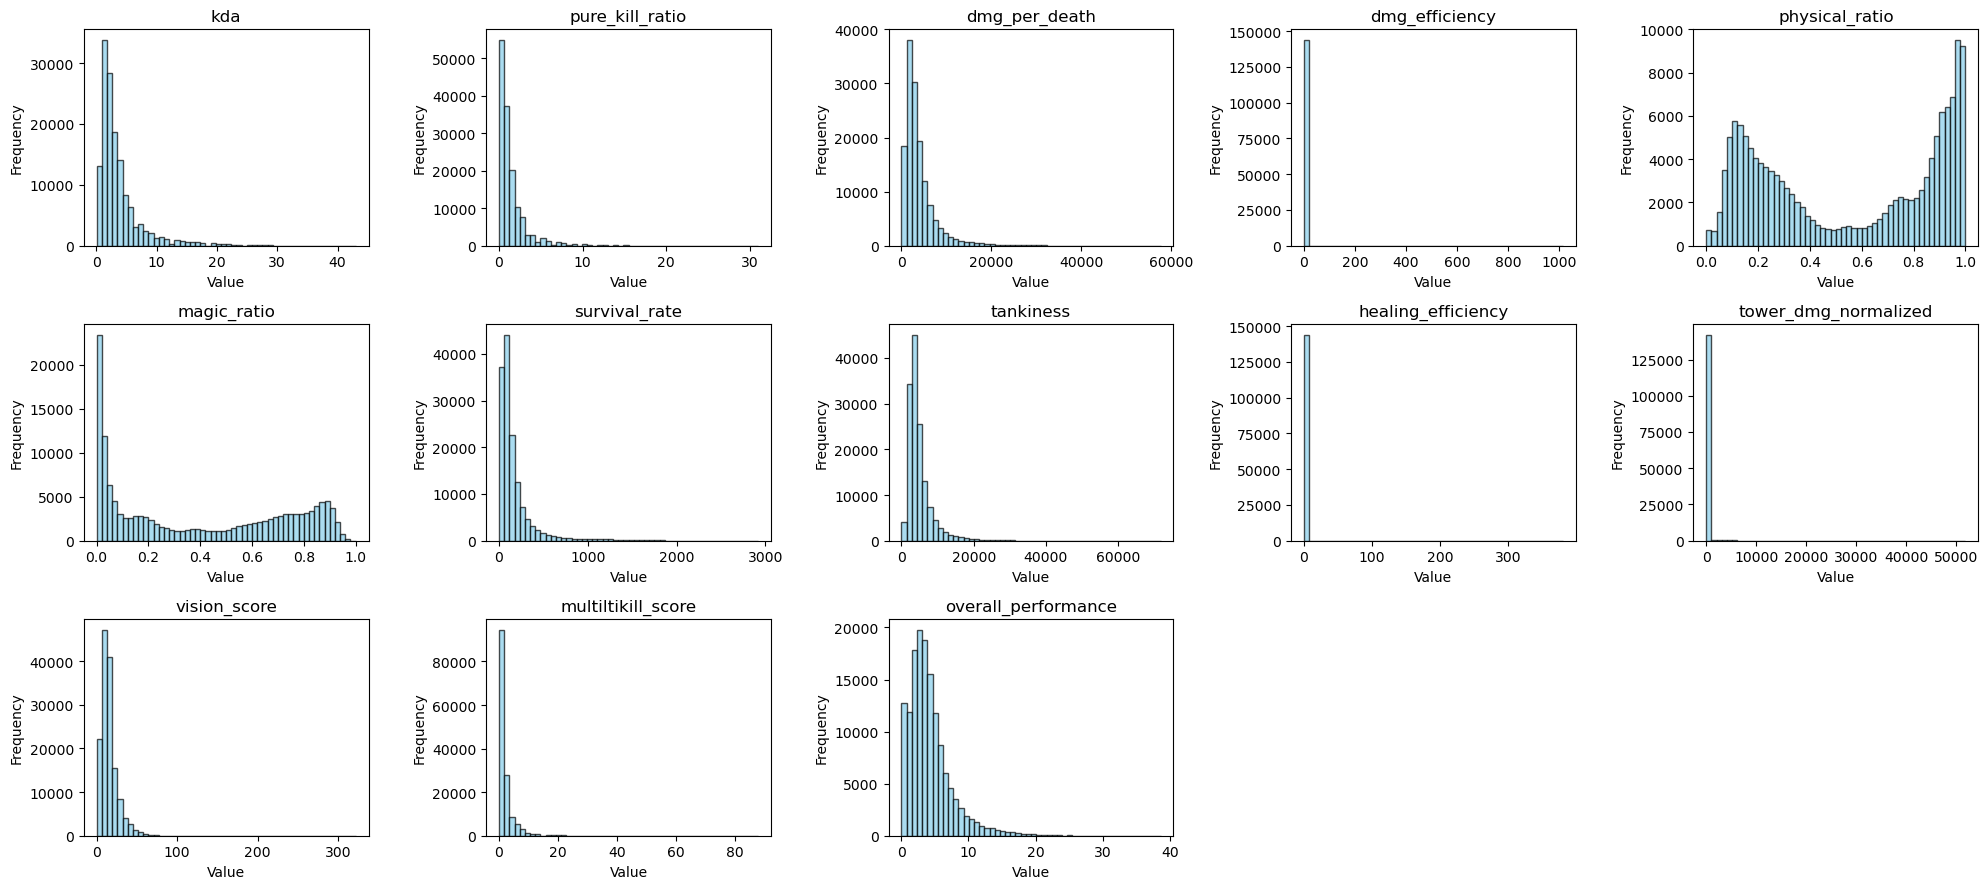

In [4]:
# ヒストグラムのプロット
target_cols = [
    "kda",
    "pure_kill_ratio",
    "dmg_per_death",
    "dmg_efficiency",
    "physical_ratio",
    "magic_ratio",
    "survival_rate",
    "tankiness",
    "healing_efficiency",
    "tower_dmg_normalized",
    "vision_score",
    "multiltikill_score",
    "overall_performance"
]

n_cols = 5
n_rows = (len(target_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(target_cols):
    axes[idx].hist(train_df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

# 余ったサブプロットを削除
for idx in range(len(target_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



In [5]:
train_df[['dmg_efficiency', 'healing_efficiency']].describe()

,dmg_efficiency,healing_efficiency
count,144000.000000,144000.000000
mean,0.847709,0.231446
std,3.517830,1.348490
min,0.000000,0.000000
25%,0.467353,0.102122
50%,0.707965,0.180482
75%,1.052974,0.285003
max,1015.000000,380.000000


### LightGBMモデルの構築（ベースライン）

Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.327686	valid_0's binary_logloss: 0.337904
[200]	training's binary_logloss: 0.303919	valid_0's binary_logloss: 0.323713
[300]	training's binary_logloss: 0.290682	valid_0's binary_logloss: 0.320422
[400]	training's binary_logloss: 0.28001	valid_0's binary_logloss: 0.318897
[500]	training's binary_logloss: 0.270498	valid_0's binary_logloss: 0.317616
[600]	training's binary_logloss: 0.261921	valid_0's binary_logloss: 0.317102
[700]	training's binary_logloss: 0.253904	valid_0's binary_logloss: 0.316703
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.254076	valid_0's binary_logloss: 0.316662
Last train loss: 0.2502
Last valid loss: 0.3167


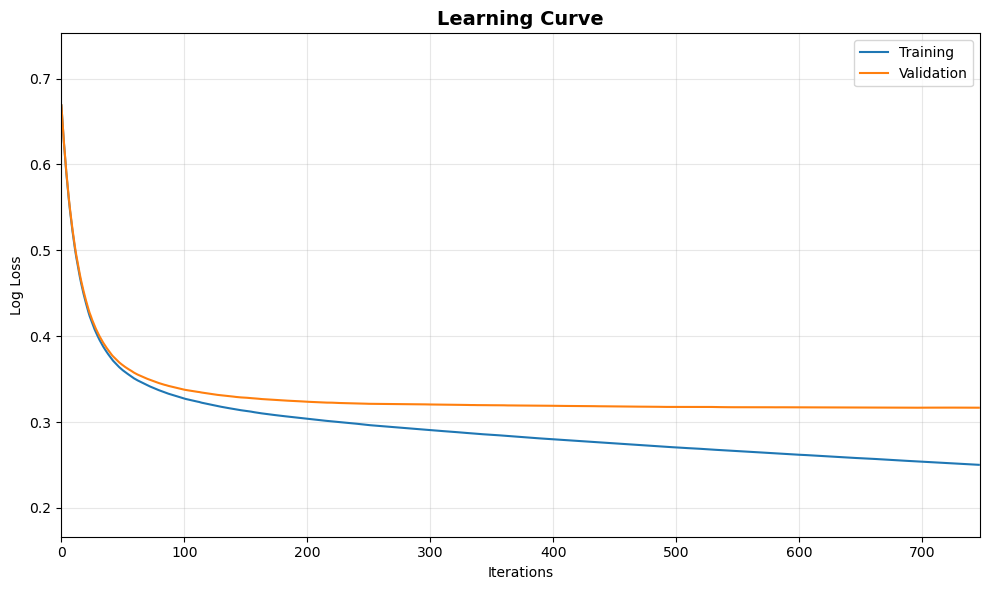

Best iteration: 697


In [6]:
import lightgbm as lgb

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

evals_result = {}
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=['training', 'valid_0'],
    callbacks=[
        lgb.record_evaluation(evals_result), 
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

# 学習曲線の可視化
train_loss = evals_result['training']['binary_logloss'][-1]
valid_loss = evals_result['valid_0']['binary_logloss'][-1]

print(f'Last train loss: {train_loss:.4f}')
print(f'Last valid loss: {valid_loss:.4f}')

# プロット
lgb.plot_metric(evals_result, metric='binary_logloss', figsize=(10, 6))
plt.title('Learning Curve', fontsize=14, fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.legend(['Training', 'Validation'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best iteration: {model.best_iteration}")


### 評価

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
# 予測
y_train_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_valid_pred = model.predict(X_val, num_iteration=model.best_iteration)


optimal_threshold = 0.5078 # 最適閾値
y_train_pred_binary = (y_train_pred > optimal_threshold).astype(int) # type: ignore
y_valid_pred_binary = (y_valid_pred > optimal_threshold).astype(int) # type: ignore

In [9]:
# 精度計算
train_acc = accuracy_score(y_train, y_train_pred_binary)
valid_acc = accuracy_score(y_val, y_valid_pred_binary)
train_auc = roc_auc_score(y_train, y_train_pred) # type: ignore
valid_auc = roc_auc_score(y_val, y_valid_pred) # type: ignore

In [10]:
print(f"\n📊 精度:")
print(f"  トレーニング Accuracy: {train_acc:.4f}")
print(f"  検証 Accuracy: {valid_acc:.4f}")
print(f"  トレーニング AUC: {train_auc:.4f}")
print(f"  検証 AUC: {valid_auc:.4f}")


📊 精度:
  トレーニング Accuracy: 0.8901
  検証 Accuracy: 0.8549
  トレーニング AUC: 0.9629
  検証 AUC: 0.9378


In [11]:
# 詳細なレポート
print(classification_report(y_val, y_valid_pred_binary, target_names=['Loss', 'Win']))

              precision    recall  f1-score   support

        Loss       0.85      0.86      0.86     14408
         Win       0.86      0.85      0.85     14392

    accuracy                           0.85     28800
   macro avg       0.85      0.85      0.85     28800
weighted avg       0.85      0.85      0.85     28800



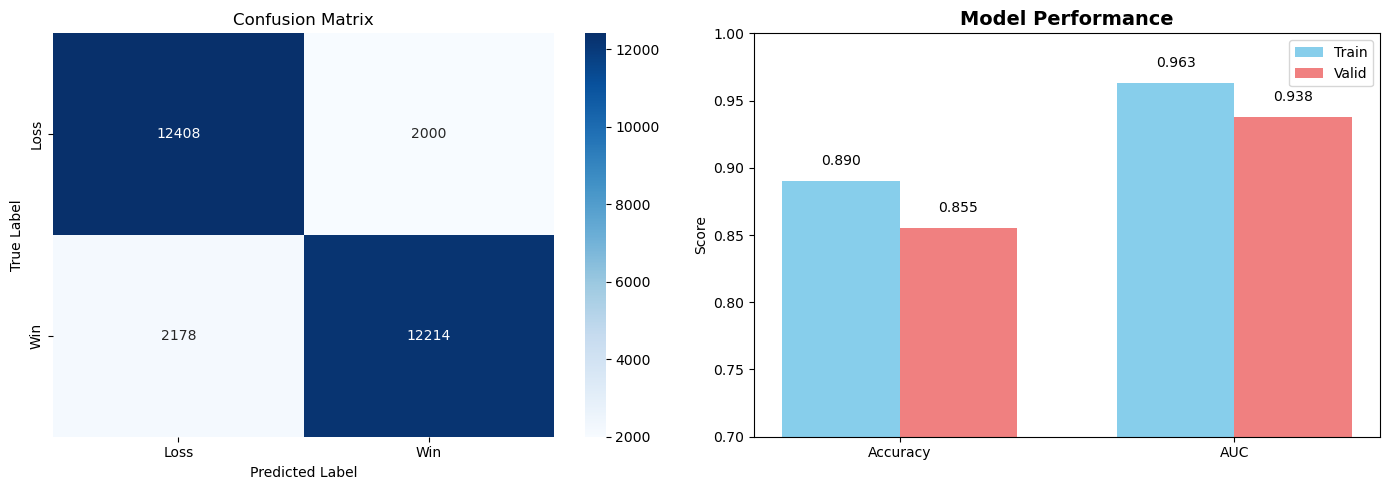

In [12]:
# 混同行列
cm = confusion_matrix(y_val, y_valid_pred_binary)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# 精度比較
metrics = ['Accuracy', 'AUC']
train_scores = [train_acc, train_auc]
valid_scores = [valid_acc, valid_auc]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, train_scores, width, label='Train', color='skyblue')
axes[1].bar(x + width/2, valid_scores, width, label='Valid', color='lightcoral')
axes[1].set_ylabel('Score')
axes[1].set_title('Model Performance', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0.7, 1.0])

# 値をバーの上に表示
for i, (train_score, valid_score) in enumerate(zip(train_scores, valid_scores)):
    axes[1].text(i - width/2, train_score + 0.01, f'{train_score:.3f}', ha='center', va='bottom',fontsize=10)
    axes[1].text(i + width/2, valid_score + 0.01, f'{valid_score:.3f}', ha='center', va='bottom',fontsize=10)


plt.tight_layout()
plt.show()

AUCに対して,ACCが低いので,閾値を最適化する.
### Youden's Index
TPR: True Positive Rate(真陽性率)

FPR: False Positive Rate(偽陽性率)
$$
\begin{align*}
TPR &= \frac{TP}{TP + FN} \\
FPR &= \frac{FP}{FP + TN} \\

optimal\_idx &= \arg\max (TPR - FPR)
\end{align*}
$$





In [13]:
# 閾値の最適化
from sklearn.metrics import roc_curve

# ROC曲線から最適閾値を探す
fpr, tpr, thresholds = roc_curve(y_val, y_valid_pred) # type: ignore
# Youden's Index（TPR - FPR が最大になる点）
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"最適閾値: {optimal_threshold:.4f}")

# 最適閾値で予測
y_pred_optimal = (y_valid_pred >= optimal_threshold).astype(int)
optimal_accuracy = accuracy_score(y_val, y_pred_optimal)

print(f"閾値0.5でのAccuracy: {accuracy_score(y_val, y_valid_pred_binary):.4f}")
print(f"最適閾値でのAccuracy: {optimal_accuracy:.4f}")

最適閾値: 0.5218
閾値0.5でのAccuracy: 0.8549
最適閾値でのAccuracy: 0.8554


### 特徴量重要度の確認

In [14]:
feature_columns = train_df.drop(['win'], axis=1).columns
type(feature_columns)

pandas.core.indexes.base.Index

In [15]:

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))

               feature    importance
                   kda 426913.099758
  tower_dmg_normalized  93244.182181
          dmgtoturrets  45314.551343
longesttimespentliving  24208.954353
   overall_performance  24202.042871
           totdmgdealt  20590.982611
                deaths  16440.898122
           totdmgtaken  15918.812619
         totdmgtochamp  15011.424335
         magicdmgtaken  14804.227966
    healing_efficiency  13274.088482
               assists  13219.396852
          truedmgdealt  11925.784155
      physicaldmgdealt  11569.312207
          truedmgtaken  10485.190128
        physdmgtochamp   8797.829090
        totunitshealed   8638.377589
             tankiness   8588.758512
        physical_ratio   8314.736133
        dmg_efficiency   6841.943840


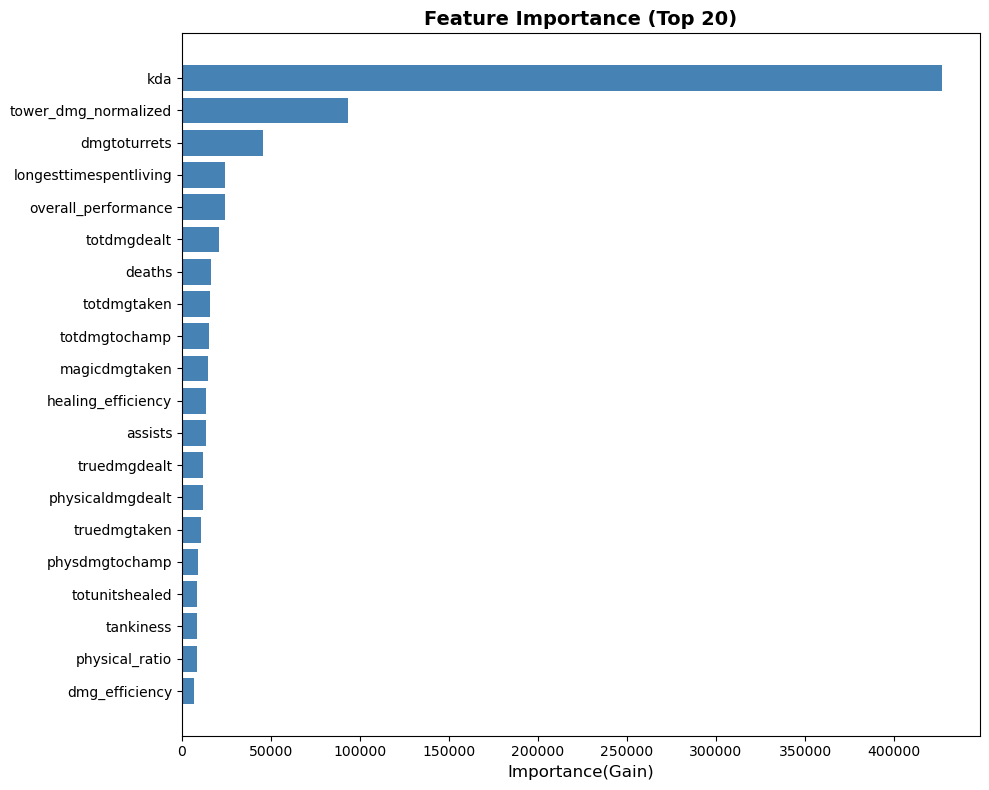

In [16]:
# 可視化
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature']) # type: ignore
plt.xlabel('Importance(Gain)', fontsize=12)
plt.title('Feature Importance (Top 20)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [17]:
X_test.head()

,id,kills,deaths,assists,largestkillingspree,largestmultikill,longesttimespentliving,doublekills,triplekills,quadrakills,...,dmg_efficiency,physical_ratio,magic_ratio,survival_rate,tankiness,healing_efficiency,tower_dmg_normalized,vision_score,multiltikill_score,overall_performance
0,144000,3,12,6,2,1,317,0,0,0,...,0.300586,0.868584,0.010380,26.416667,2331.833333,0.210564,0.078864,11,0,1.551619
1,144001,1,3,22,0,1,1636,0,0,0,...,1.022555,0.214266,0.784842,545.333333,7478.000000,0.054783,0.736553,12,0,6.219013
2,144002,8,7,4,2,2,544,2,0,0,...,0.686503,0.669279,0.267736,77.714286,3476.000000,0.144953,7.985294,16,4,4.389642
3,144003,8,4,10,3,1,446,0,0,0,...,0.619906,0.875359,0.056026,111.500000,5907.750000,0.525073,9.710762,13,0,5.124757
4,144004,5,8,5,2,1,495,0,0,0,...,0.575794,0.752615,0.176187,61.875000,4573.250000,0.195430,8.909091,23,0,2.903371


In [18]:
X_test.drop(['timecc', 'id'], axis=1, inplace=True)
# テストデータで予測
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_test_pred_binary = (y_test_pred > optimal_threshold).astype(int)

In [19]:
print(f"✅ 予測完了")
print(f"予測されたクラス分布:")
print(f"  勝利予測: {sum(y_test_pred_binary==1)} ({sum(y_test_pred_binary==1)/len(y_test_pred_binary)*100:.2f}%)")
print(f"  敗北予測: {sum(y_test_pred_binary==0)} ({sum(y_test_pred_binary==0)/len(y_test_pred_binary)*100:.2f}%)")


✅ 予測完了
予測されたクラス分布:
  勝利予測: 17458 (48.49%)
  敗北予測: 18542 (51.51%)


In [23]:
import os
# 提出用ファイル作成
save_path_submission = '../outputs/submissions'
save_path_model = '../outputs/models/basemodel_lgbm'
submission = pd.DataFrame({
    'id': test_df['id'],
    'win': y_test_pred_binary
})

os.makedirs(save_path_submission, exist_ok=True)
os.makedirs(save_path_model, exist_ok=True)
submission.to_csv(os.path.join(save_path_submission, 'submission_basemodel.csv'), index=False)

# モデル保存
model.save_model(os.path.join(save_path_model, 'lgbm_basemodel.txt'))
